<a href="https://colab.research.google.com/github/lorebianchi98/BrainTumorClassification/blob/main/4_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification using DenseNet121
In this notebook we are going to perform the classification of the brain tumor using as base CNN DenseNet121.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
% run /content/gdrive/MyDrive/BrainTumorClassifier/utilities.ipynb

We also perform the download and the unzipping of the dataset from the drive folder.

In [ ]:
!unzip -q '/content/gdrive/MyDrive/BrainTumorClassifier/brain-tumor-mri-splits.zip' -d '/'

# Hardware Accelerator test

First we need to check if the hardware accelaration is enabled, since training a CNN on a CPU could be infeasible.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading

Now we need to create the Dataset objects from the sets directory. We use the [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function provided by Keras. 

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 4213 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 1406 files belonging to 4 classes.


# 256 Dense Neurons
Initially we are going to train a Multilayer Perceptron Network to classify brain tumor having as input the features extracted by DenseNet121. The last layer of DenseNet121 is removed, since it was a MLP Network built to classify ImageNet Dataset. The VGG16 layers are freezed in this part of training. 

In [ ]:
base_cnn = keras.applications.DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_cnn.trainable = False

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
inputs = keras.Input(shape=(224,224,3))

x = data_augmentation_layers(inputs)

x = keras.applications.densenet.preprocess_input(x)
x = base_cnn(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs=output, name="DenseNet121")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                       

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.6580
Epoch 1: val_loss improved from inf to 0.47880, saving model to model/DenseNet121.h5
66/66 [==============================] - 29s 215ms/step - loss: 0.8927 - accuracy: 0.6580 - val_loss: 0.4788 - val_accuracy: 0.8369
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.8125
Epoch 2: val_loss improved from 0.47880 to 0.38313, saving model to model/DenseNet121.h5
66/66 [==============================] - 12s 173ms/step - loss: 0.4958 - accuracy: 0.8125 - val_loss: 0.3831 - val_accuracy: 0.8632
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8460
Epoch 3: val_loss improved from 0.38313 to 0.36394, saving model to model/DenseNet121.h5
66/66 [==============================] - 12s 173ms/step - loss: 0.4119 - accuracy: 0.8460 - val_loss: 0.3639 - val_accuracy: 0.8689
Epoch 4/50
66/66 [==============================] - ETA: 0s

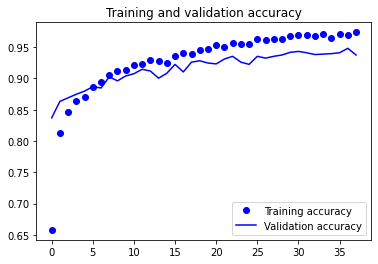

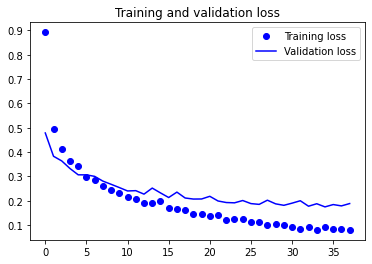

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 5s 148ms/step - loss: 0.1736 - accuracy: 0.9424
Loss on test set: 0.1735599786043167
Accuracy on test set: 0.9423897862434387
              precision    recall  f1-score   support

      glioma     0.9375    0.9231    0.9302       325
  meningioma     0.8933    0.8906    0.8919       329
     notumor     0.9730    0.9900    0.9814       400
   pituitary     0.9573    0.9545    0.9559       352

    accuracy                         0.9424      1406
   macro avg     0.9403    0.9395    0.9399      1406
weighted avg     0.9422    0.9424    0.9423      1406



22/22 [==============================] - 2s 114ms/step


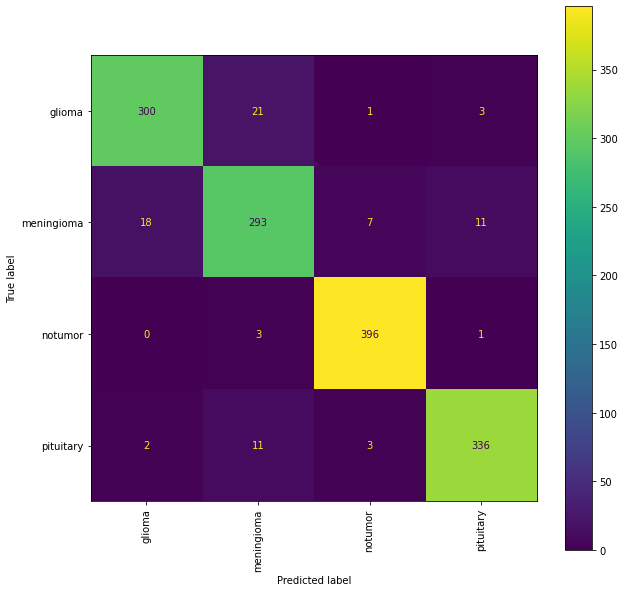

In [ ]:
plot_confusionmatrix(model, test_ds)

# Fine Tuning last block
Now it is time to unfreeze the last block of VGG16 to fine tune its weigths on our dataset.

In [ ]:
trainable = False

for layer in model.get_layer("densenet121").layers:
    if layer.name == 'conv5_block15_0_bn':
        trainable = True
    is_bn = layer.name.endswith('bn')  # keep BatchNorm freezed, good practice for finetuned models
    if not is_bn:
      layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0002)
model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                       

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9699
Epoch 1: val_loss improved from inf to 0.18465, saving model to model/DenseNet121_Finetuned.h5
66/66 [==============================] - 20s 202ms/step - loss: 0.0834 - accuracy: 0.9699 - val_loss: 0.1847 - val_accuracy: 0.9259
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9777
Epoch 2: val_loss did not improve from 0.18465
66/66 [==============================] - 11s 167ms/step - loss: 0.0646 - accuracy: 0.9777 - val_loss: 0.1850 - val_accuracy: 0.9395
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9827
Epoch 3: val_loss improved from 0.18465 to 0.17153, saving model to model/DenseNet121_Finetuned.h5
66/66 [==============================] - 12s 177ms/step - loss: 0.0572 - accuracy: 0.9827 - val_loss: 0.1715 - val_accuracy: 0.9480
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0548 - accu

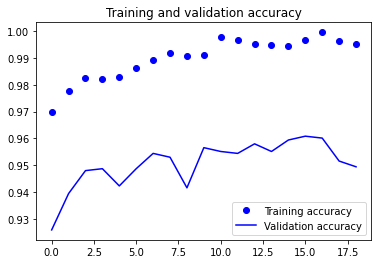

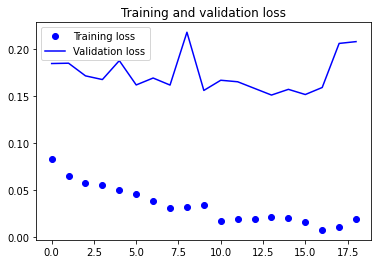

In [ ]:
model, history = run_model(model, model.name + "_Finetuned", train_ds, val_ds, 50, patience=5, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

22/22 [==============================] - 4s 125ms/step - loss: 0.1604 - accuracy: 0.9509
Loss on test set: 0.1603803038597107
Accuracy on test set: 0.9509246349334717
              precision    recall  f1-score   support

      glioma     0.9275    0.9446    0.9360       325
  meningioma     0.9094    0.9149    0.9121       329
     notumor     0.9778    0.9925    0.9851       400
   pituitary     0.9822    0.9432    0.9623       352

    accuracy                         0.9509      1406
   macro avg     0.9492    0.9488    0.9489      1406
weighted avg     0.9513    0.9509    0.9510      1406



22/22 [==============================] - 2s 114ms/step


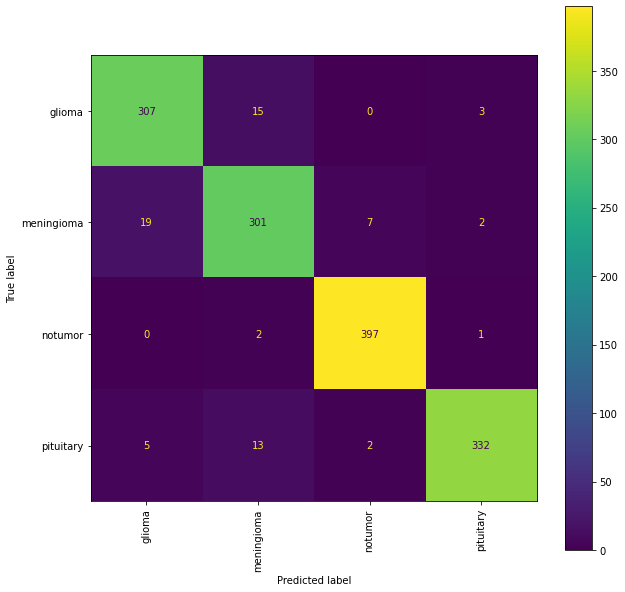

In [ ]:
plot_confusionmatrix(model, test_ds)